In [2]:
import sys 
#sys.path.append("")
#import io

from dataset import MorphoMNISTLike

In [2]:
%pip install -q diffusers

Note: you may need to restart the kernel to use updated packages.


In [3]:
attribute_size = {
        "thickness": 1,
        "intensity": 1,
        "digit": 10
    }

train_set = MorphoMNISTLike(attribute_size, train=True)
val_set =  MorphoMNISTLike(attribute_size, train=False)
print(len(train_set), len(val_set))
train_set[0][0].shape , train_set[0][1].shape

60000 10000


(torch.Size([1, 32, 32]), torch.Size([12]))

In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel, DDIMScheduler, DDIMInverseScheduler
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

/home/n.spyrou/crf_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [5]:
tr_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader  = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
print(len(tr_loader), len(val_loader))

1875 313


In [6]:
class embedfc(nn.Module):
    def __init__(self, input_dim=12, emb_dim=128):
        super(embedfc, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [7]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, context_dim=12, emb_dim=128):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
  #  self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=32,           # the target image resolution
        in_channels=1 + emb_dim, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

    self.fc_emb = embedfc(input_dim=context_dim, emb_dim=emb_dim)

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, y, drop_prob = 0.15):
    # Shape of x:
    bs, ch, w, h = x.shape
    # class conditioning in right shape to add as additional input channels
    #class_cond = self.class_emb(class_labels) # Map to embedding dimension
    #class_cond = self.fc_emb(c)
    mask = torch.rand(y.shape[0]) < drop_prob
    y_drop_out = y.clone()
    y_drop_out[mask] = 0
    
    context_cond = self.fc_emb(y_drop_out)
    context_cond = context_cond.view(bs, context_cond.shape[1], 1, 1).expand(bs, context_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, context_cond), 1) # (bs, 5, 28, 28)
    #print(net_input.shape)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [8]:
model = ClassConditionedUnet(context_dim=12, emb_dim=128).to(device)

  0%|          | 0/1875 [00:00<?, ?it/s]

tensor([606,  65, 780, 395, 671, 359, 424, 478, 257, 929, 819, 776, 527, 898,
        933, 173, 469, 363, 936, 191,  14, 809, 777, 213, 523, 598, 143, 255,
        848, 556, 421,  72], device='cuda:0')
tensor(-1.6831, device='cuda:0') tensor(3.7614, device='cuda:0')
Finished training epoch 0. mean_train loss: 00nan


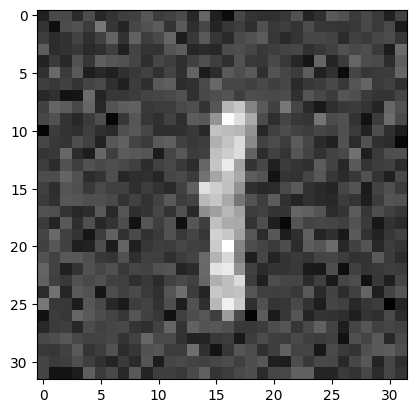

In [124]:
import numpy as np

n_epochs = 50
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []
val_losses = []
best_val_loss = np.inf

# The training loop
for epoch in range(n_epochs):
    losses = []
    val_losses = []
    for batch in tqdm(tr_loader):
        x , y = batch[0].to(device), batch[1].to(device)

        # Get some data and prepare the corrupted version
       # x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
       # y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        print(timesteps)
        plt.imshow(noisy_x[1].squeeze(0).cpu(),cmap="gray")
        print(noisy_x[1].min(), noisy_x.max())
        break

        # Get the model prediction
        pred = model(noisy_x, timesteps, y, drop_prob = 0.15) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    print(f'Finished training epoch {epoch}. mean_train loss: {torch.tensor(losses).mean():05f}')
   # print()
    break


    for batch in tqdm(val_loader):

        x , y = batch[0].to(device), batch[1].to(device)

        # Get some data and prepare the corrupted version
       # x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
       # y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get some data and prepare the corrupted version
      #  x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
      #  y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)

        with torch.no_grad():
            noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
            pred = model(noisy_x, timesteps, y, drop_prob = 0) # Note that we pass in the labels y

        # Calculate the loss
            val_loss = loss_fn(pred, noise) # How close is the output to the noise
        
        val_losses.append(val_loss.item())
    current_val_loss = torch.tensor(val_losses).mean()
    
    print(f'Finished val epoch {epoch}. mean_val loss: {current_val_loss:05f}')

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        print("Save checkpoint")
        torch.save(model.state_dict(), "checkpoint.pth")
    print()

In [ ]:
#@markdown Sampling some different digits:

'''
def qualitative_eval_model(noise_scheduler):
# Prepare random x to start from, plus some desired labels y
    x = torch.randn(80, 1, 28, 28).to(device)
    y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
    net = ClassConditionedUnet().to(device)

    net.load_state_dict(torch.load("checkpoints/checkpoint.pth"))
    net.eval()

# Sampling loop
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
        with torch.no_grad():
            residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
        x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='gray')

    return
    '''

tensor([[-0.4531,  0.1798,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000]], device='cuda:0')


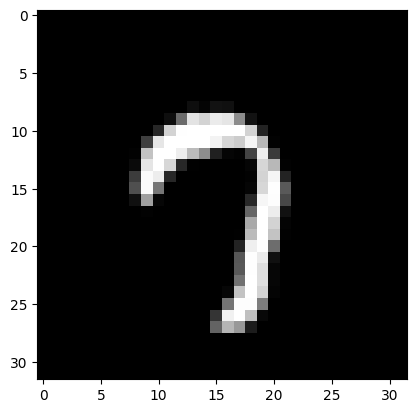

In [9]:
test_data_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True, num_workers=7)
iterator = iter(test_data_loader)
batch = next(iterator)

img , y = batch[0].to(device) , batch[1].to(device)
print(y)
plt.imshow(img.squeeze(0).squeeze(0).cpu(), cmap = "gray")

In [13]:
x = torch.randn(1, 1, 32, 32).to(device)
noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
noise_scheduler.set_timesteps(num_inference_steps=150)

y = torch.tensor([[-0.0644, 0.7502, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000]], device='cuda:0')

model.load_state_dict(torch.load("checkpoint_morpho_2.pth"))
model.eval()

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # Get model pred
       # print(t)
        with torch.no_grad():
            residual = model(x, t, y, drop_prob=0)  # Again, note that we pass in our labels y

    # Update sample with step
        x = noise_scheduler.step(residual, t, x).prev_sample

22it [00:00, 100.23it/s]

150it [00:01, 107.71it/s]


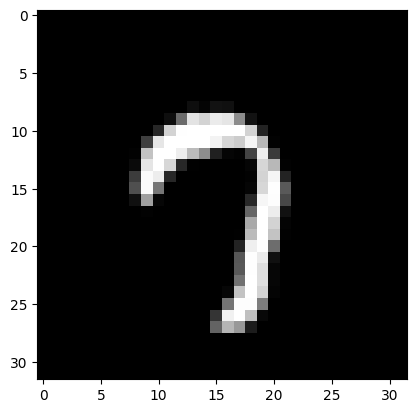

In [11]:
plt.imshow(img.squeeze(0).squeeze(0).cpu(), cmap = "gray")

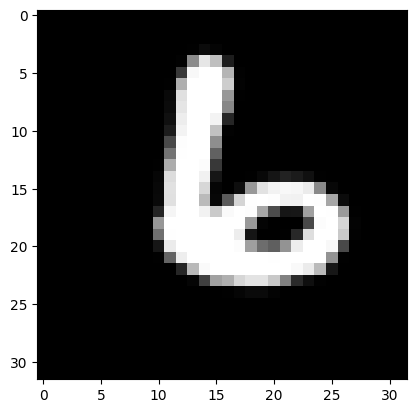

In [14]:
plt.imshow(x.squeeze(0).squeeze(0).cpu(), cmap = "gray")

In [15]:
import math
from dataclasses import dataclass
from typing import Optional, Tuple, Union

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.utils import BaseOutput, deprecate
from diffusers.schedulers.scheduling_utils import SchedulerMixin


@dataclass
class DDIMSchedulerOutput(BaseOutput):
    """
    Output class for the scheduler's step function output.

    Args:
        prev_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample (x_{t-1}) of previous timestep. `prev_sample` should be used as next model input in the
            denoising loop.
        next_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample (x_{t+1}) of previous timestep. `next_sample` should be used as next model input in the
            reverse denoising loop.
        pred_original_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            The predicted denoised sample (x_{0}) based on the model output from the current timestep.
            `pred_original_sample` can be used to preview progress or for guidance.
    """

    prev_sample: Optional[torch.FloatTensor] = None
    next_sample: Optional[torch.FloatTensor] = None
    pred_original_sample: Optional[torch.FloatTensor] = None


def betas_for_alpha_bar(num_diffusion_timesteps, max_beta=0.999) -> torch.Tensor:
    """
    Create a beta schedule that discretizes the given alpha_t_bar function, which defines the cumulative product of
    (1-beta) over time from t = [0,1].

    Contains a function alpha_bar that takes an argument t and transforms it to the cumulative product of (1-beta) up
    to that part of the diffusion process.


    Args:
        num_diffusion_timesteps (`int`): the number of betas to produce.
        max_beta (`float`): the maximum beta to use; use values lower than 1 to
                     prevent singularities.

    Returns:
        betas (`np.ndarray`): the betas used by the scheduler to step the model outputs
    """

    def alpha_bar(time_step):
        return math.cos((time_step + 0.008) / 1.008 * math.pi / 2) ** 2

    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)


class DDIMScheduler2(SchedulerMixin, ConfigMixin):
    """
    Denoising diffusion implicit models is a scheduler that extends the denoising procedure introduced in denoising
    diffusion probabilistic models (DDPMs) with non-Markovian guidance.

    [`~ConfigMixin`] takes care of storing all config attributes that are passed in the scheduler's `__init__`
    function, such as `num_train_timesteps`. They can be accessed via `scheduler.config.num_train_timesteps`.
    [`~ConfigMixin`] also provides general loading and saving functionality via the [`~ConfigMixin.save_config`] and
    [`~ConfigMixin.from_config`] functions.

    For more details, see the original paper: https://arxiv.org/abs/2010.02502

    Args:
        num_train_timesteps (`int`): number of diffusion steps used to train the model.
        beta_start (`float`): the starting `beta` value of inference.
        beta_end (`float`): the final `beta` value.
        beta_schedule (`str`):
            the beta schedule, a mapping from a beta range to a sequence of betas for stepping the model. Choose from
            `linear`, `scaled_linear`, or `squaredcos_cap_v2`.
        trained_betas (`np.ndarray`, optional):
            option to pass an array of betas directly to the constructor to bypass `beta_start`, `beta_end` etc.
        clip_sample (`bool`, default `True`):
            option to clip predicted sample between -1 and 1 for numerical stability.
        set_alpha_to_one (`bool`, default `True`):
            each diffusion step uses the value of alphas product at that step and at the previous one. For the final
            step there is no previous alpha. When this option is `True` the previous alpha product is fixed to `1`,
            otherwise it uses the value of alpha at step 0.
        steps_offset (`int`, default `0`):
            an offset added to the inference steps. You can use a combination of `offset=1` and
            `set_alpha_to_one=False`, to make the last step use step 0 for the previous alpha product, as done in
            stable diffusion.

    """

    @register_to_config
    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        beta_schedule: str = "linear",
        trained_betas: Optional[np.ndarray] = None,
        clip_sample: bool = True,
        set_alpha_to_one: bool = True,
        steps_offset: int = 0,
    ):
        if trained_betas is not None:
            self.betas = torch.from_numpy(trained_betas)
        elif beta_schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = (
                torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
            )
        elif beta_schedule == "squaredcos_cap_v2":
            # Glide cosine schedule
            self.betas = betas_for_alpha_bar(num_train_timesteps)
        else:
            raise NotImplementedError(f"{beta_schedule} does is not implemented for {self.__class__}")

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # At every step in ddim, we are looking into the previous alphas_cumprod
        # For the final step, there is no previous alphas_cumprod because we are already at 0
        # `set_alpha_to_one` decides whether we set this parameter simply to one or
        # whether we use the final alpha of the "non-previous" one.
        self.final_alpha_cumprod = torch.tensor(1.0) if set_alpha_to_one else self.alphas_cumprod[0]

        # standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0

        # setable values
        self.num_inference_steps = None
        self.timesteps = torch.from_numpy(np.arange(0, num_train_timesteps)[::-1].copy().astype(np.int64))

    def _get_variance(self, timestep, prev_timestep):
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev

        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)

        return variance

    def set_timesteps(self, num_inference_steps: int, device: Union[str, torch.device] = None):
        """
        Sets the discrete timesteps used for the diffusion chain. Supporting function to be run before inference.
        Args:
            num_inference_steps (`int`):
                the number of diffusion steps used when generating samples with a pre-trained model.
        """
        self.num_inference_steps = num_inference_steps
        step_ratio = self.config.num_train_timesteps // self.num_inference_steps
        # creates integer timesteps by multiplying by ratio
        # casting to int to avoid issues when num_inference_step is power of 3
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps).to(device)
        self.timesteps += self.config.steps_offset
        
    def scale_model_input(self, sample: torch.FloatTensor, timestep: Optional[int] = None) -> torch.FloatTensor:
        """
        Ensures interchangeability with schedulers that need to scale the denoising model input depending on the
        current timestep.
        Args:
            sample (`torch.FloatTensor`): input sample
            timestep (`int`, optional): current timestep
        Returns:
            `torch.FloatTensor`: scaled input sample
        """
        return sample

    def step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        return_dict: bool = True,
    ) -> Union[DDIMSchedulerOutput, Tuple]:
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`): direct output from learned diffusion model.
            timestep (`int`): current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                current instance of sample being created by diffusion process.
            eta (`float`): weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`): TODO
            generator: random number generator.
            return_dict (`bool`): option for returning tuple rather than DDIMSchedulerOutput class

        Returns:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] or `tuple`:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] if `return_dict` is True, otherwise a `tuple`. When
            returning a tuple, the first element is the sample tensor.

        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # See formulas (12) and (16) of DDIM paper https://arxiv.org/pdf/2010.02502.pdf
        # Ideally, read DDIM paper in-detail understanding

        # Notation (<variable name> -> <name in paper>
        # - pred_noise_t -> e_theta(x_t, t)
        # - pred_original_sample -> f_theta(x_t, t) or x_0
        # - std_dev_t -> sigma_t
        # - eta -> η
        # - pred_sample_direction -> "direction pointing to x_t"
        # - pred_prev_sample -> "x_t-1"

        # 1. get previous step value (=t-1)
        prev_timestep = timestep - self.config.num_train_timesteps // self.num_inference_steps

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t

        # 3. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 4. Clip "predicted x_0"
        if self.config.clip_sample:
            pred_original_sample = torch.clamp(pred_original_sample, -1, 1)

        # 5. compute variance: "sigma_t(η)" -> see formula (16)
        # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        variance = self._get_variance(timestep, prev_timestep)
        std_dev_t = eta * variance ** (0.5)

        if use_clipped_model_output:
            # the model_output is always re-derived from the clipped x_0 in Glide
            model_output = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

        # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * model_output

        # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

        if eta > 0:
            device = model_output.device if torch.is_tensor(model_output) else "cpu"
            noise = torch.randn(model_output.shape, generator=generator).to(device)
            variance = self._get_variance(timestep, prev_timestep) ** (0.5) * eta * noise

            prev_sample = prev_sample + variance

        if not return_dict:
            return (prev_sample,)

        return DDIMSchedulerOutput(prev_sample=prev_sample, pred_original_sample=pred_original_sample)

    def reverse_step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        return_dict: bool = True,
    ) -> Union[DDIMSchedulerOutput, Tuple]:
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`): direct output from learned diffusion model.
            timestep (`int`): current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                current instance of sample being created by diffusion process.
            eta (`float`): weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`): TODO
            generator: random number generator.
            return_dict (`bool`): option for returning tuple rather than DDIMSchedulerOutput class

        Returns:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] or `tuple`:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] if `return_dict` is True, otherwise a `tuple`. When
            returning a tuple, the first element is the sample tensor.

        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # See formulas (12) and (16) of DDIM paper https://arxiv.org/pdf/2010.02502.pdf
        # Ideally, read DDIM paper in-detail understanding

        # Notation (<variable name> -> <name in paper>
        # - pred_noise_t -> e_theta(x_t, t)
        # - pred_original_sample -> f_theta(x_t, t) or x_0
        # - std_dev_t -> sigma_t
        # - eta -> η
        # - pred_sample_direction -> "direction pointing to x_t"
        # - pred_prev_sample -> "x_t-1"

        # 1. get previous step value (=t-1)
        next_timestep = min(self.config.num_train_timesteps - 2,
                            timestep + self.config.num_train_timesteps // self.num_inference_steps)

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_next = self.alphas_cumprod[next_timestep] if next_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t

        # 3. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 4. Clip "predicted x_0"
        if self.config.clip_sample:
            pred_original_sample = torch.clamp(pred_original_sample, -1, 1)

        # 5. TODO: simple noising implementatiom
        next_sample = self.add_noise(pred_original_sample,
                                     model_output,
                                     torch.LongTensor([next_timestep]))

        # # 5. compute variance: "sigma_t(η)" -> see formula (16)
        # # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        # variance = self._get_variance(next_timestep, timestep)
        # std_dev_t = eta * variance ** (0.5)

        # if use_clipped_model_output:
        #     # the model_output is always re-derived from the clipped x_0 in Glide
        #     model_output = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

        # # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        # pred_sample_direction = (1 - alpha_prod_t_next - std_dev_t**2) ** (0.5) * model_output

        # # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        # next_sample = alpha_prod_t_next ** (0.5) * pred_original_sample + pred_sample_direction

        if not return_dict:
            return (next_sample,)

        return DDIMSchedulerOutput(next_sample=next_sample, pred_original_sample=pred_original_sample)

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        if self.alphas_cumprod.device != original_samples.device:
            self.alphas_cumprod = self.alphas_cumprod.to(original_samples.device)
        if timesteps.device != original_samples.device:
            timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = self.alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - self.alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

    def __len__(self):
        return self.config.num_train_timesteps


In [16]:
noise_scheduler = DDIMScheduler2()
#noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
#noise_scheduler_inv = DDIMInverseScheduler(num_train_timesteps=1000)

  0%|          | 0/200 [00:17<?, ?it/s]


torch.Size([1, 1, 32, 32])


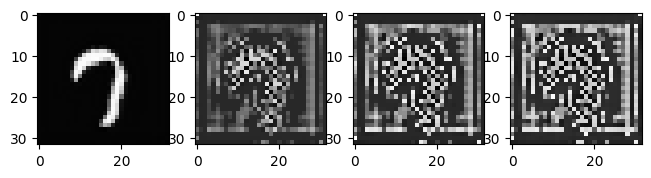

In [29]:
model.eval()

guidance_scale = 3.5
total_timesteps = 200
latent_space_depth = int(total_timesteps * 1)


model.load_state_dict(torch.load("checkpoint_morpho_2.pth"))
model.eval()

current_img = img.to(device) #inputting[None, ...].to(device)
#print(current_img.shape, current_img.device, type(current_img))
noise_scheduler.set_timesteps(num_inference_steps=total_timesteps)
timesteps = noise_scheduler.timesteps.flip(0)
## Encoding
#embed = torch.nn.Embedding(num_embeddings=3, embedding_dim=embedding_dimension, padding_idx=0).to(device)
#noise_scheduler_inv.clip_sample = False
#class_embedding = embed(torch.zeros(1).long().to(device)).unsqueeze(1)
progress_bar = tqdm(range(latent_space_depth))
cond = torch.tensor([[-0.5833, -0.4479,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')

#cond =  torch. tensor([[-0.1827,  0.3342,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
#          0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')

u_cond =  torch. tensor([[0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')

plt.figure(figsize=(20,8))

#noise_scheduler.clip_sample = True
print(current_img.shape)
#a = current_img
for i , t  in enumerate(timesteps):  # go through the noising process
    t = i
  #  print(t)
    with torch.no_grad():
       # print(current_img)
        model_output = model(current_img, torch.Tensor((t,)).cuda(), u_cond, drop_prob=0)
     #   plt.imshow(model_output.squeeze(0).squeeze(0).cpu(), cmap="gray")
       # break
    current_img  = noise_scheduler.reverse_step(model_output, t, current_img).next_sample
    if i % 50 == 0:
            plt.subplot(1, 10 , i//50+1)
            plt.imshow(current_img.squeeze(0).squeeze(0).cpu(), cmap="gray")
   # progress_bar.set_postfix({"timestep input": t})

latent_img = current_img

tensor(-1.9807, device='cuda:0') tensor(2.5892, device='cuda:0')


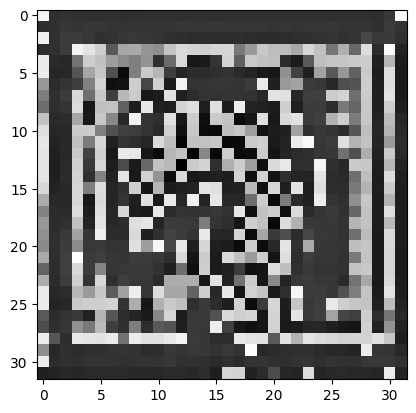

In [30]:
plt.imshow(latent_img.squeeze(0).squeeze(0).cpu(), cmap="gray")
print(latent_img.min(), latent_img.max())
#latent_img = 2 * ((latent_img - latent_img.min()) / (latent_img.max() - latent_img.min())) - 1#
#plt.imshow(latent_img.squeeze(0).squeeze(0).cpu(), cmap="gray")
#print(latent_img.min(), latent_img.max())


In [31]:
#cond = torch.tensor([[-0.5833, -0.4479,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
#          0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')

conditioning = torch.cat((u_cond, cond),dim=0).to(device)
conditioning.shape
print(conditioning)
print(conditioning.shape)


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5833, -0.4479,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
torch.Size([2, 12])


  0%|          | 0/200 [00:00<?, ?it/s]
200it [00:02, 79.98it/s]


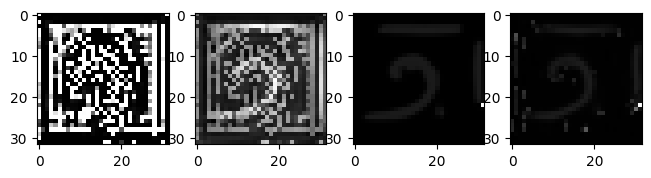

In [32]:
#conditioning = torch.tensor([7, 8]).long().to(device)

progress_bar = tqdm(range(latent_space_depth))
noise_scheduler.set_timesteps(num_inference_steps=total_timesteps)

model.load_state_dict(torch.load("checkpoint_morpho_2.pth"))
model.eval()


progress_bar = tqdm(range(latent_space_depth))
noise_scheduler.set_timesteps(num_inference_steps=total_timesteps)

current_img = latent_img #torch.randn(1,1,32,32).to(device)
plt.figure(figsize=(20,8))

for i , t in tqdm(enumerate(timesteps)):  # go through the denoising process
    t = i #latent_space_depth - i

    current_img_double = torch.cat([current_img] * 2)
    with torch.no_grad():
        model_output = model(
            current_img_double, t=torch.Tensor([t, t]).to(current_img.device), y=conditioning,  drop_prob=0)
    noise_pred_uncond, noise_pred_text = model_output.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    current_img = noise_scheduler.step(noise_pred, t, current_img).prev_sample
    
    if i % 50 == 0:
            plt.subplot(1, 10 , i//50+1)
            plt.imshow(current_img.squeeze(0).squeeze(0).cpu(), cmap="gray")

  #  progress_bar.set_postfix({"timestep input": t})
    torch.cuda.empty_cache()

In [192]:
x = torch.randn(1, 1, 32, 32).to(device)
noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
noise_scheduler.set_timesteps(num_inference_steps=150)

y = torch.tensor([[-0.0644, 0.7502, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]], device='cuda:0')

model.load_state_dict(torch.load("checkpoint.pth"))
model.eval()

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # Get model pred
       # print(t)
        with torch.no_grad():
            residual = model(x, t, y, drop_prob=0)  # Again, note that we pass in our labels y

    # Update sample with step
        x = noise_scheduler.step(residual, t, x).prev_sample

150it [00:01, 108.54it/s]


In [195]:
noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
noise_scheduler.set_timesteps(num_inference_steps=150)

x = torch.randn(1,1,32,32).to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    # Get model pred
       # print(t)
        with torch.no_grad():
            residual = model(x, t, y=conditioning[1], drop_prob=0)  # Again, note that we pass in our labels y

    # Update sample with step
        x = noise_scheduler.step(residual, t, x).prev_sample

150it [00:01, 109.11it/s]


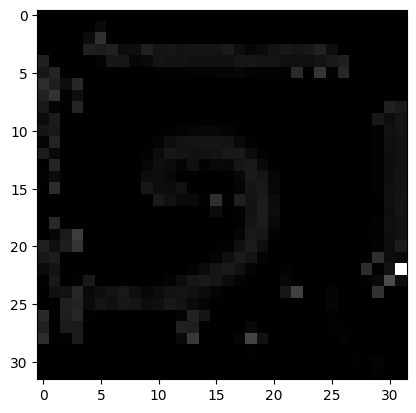

: 

In [33]:
plt.imshow(current_img.squeeze(0).squeeze(0).cpu(), cmap="gray")